In [6]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("../data")
FULL_DB_PATH = DATA_DIR / "food_full.duckdb"  # Fichier temporaire complet
FILTERED_DB_PATH = DATA_DIR / "food_canada.duckdb"  # Fichier final filtré

# Connect to the database
conn = duckdb.connect(FILTERED_DB_PATH)

Dataset Statistics:
   total_products  products_with_eco_score  products_without_eco_score  \
0           94802                    11707                       83095   

   eco_score_percentage  
0                 12.35  

---



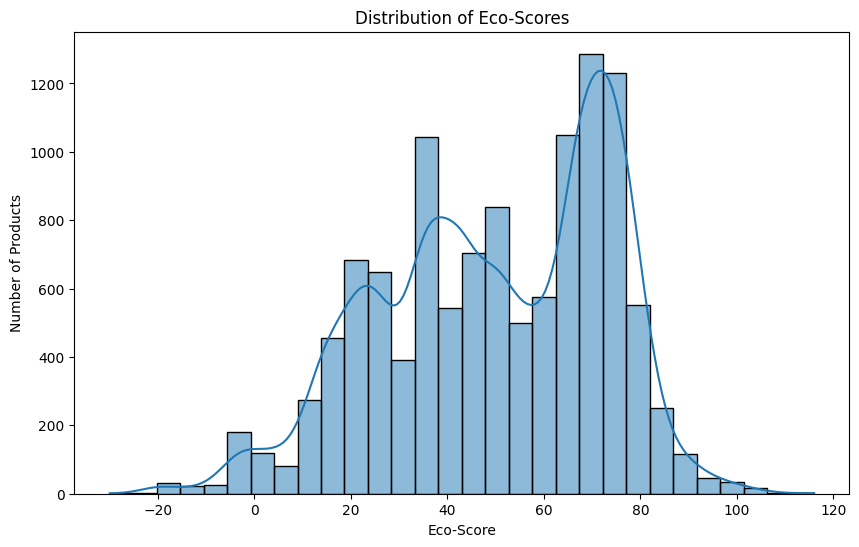

/var/folders/xz/c7tdt1ss5279tpg4_9p8r71h0000gn/T/ipykernel_46436/1442475406.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ecoscore_grade', y='count', data=df, palette=colors)


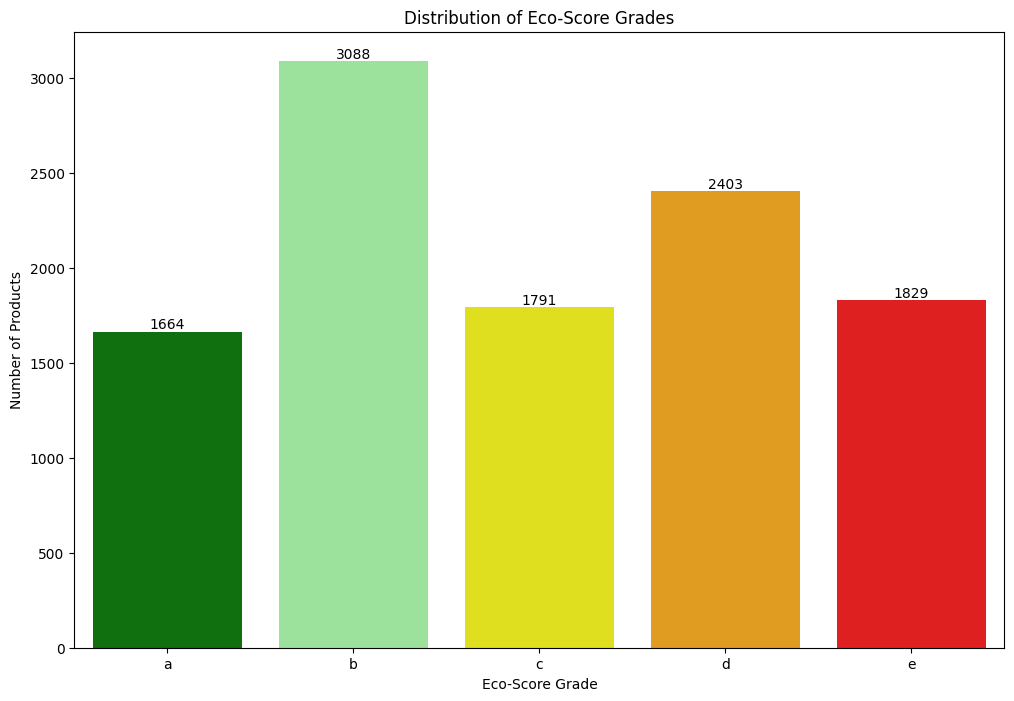

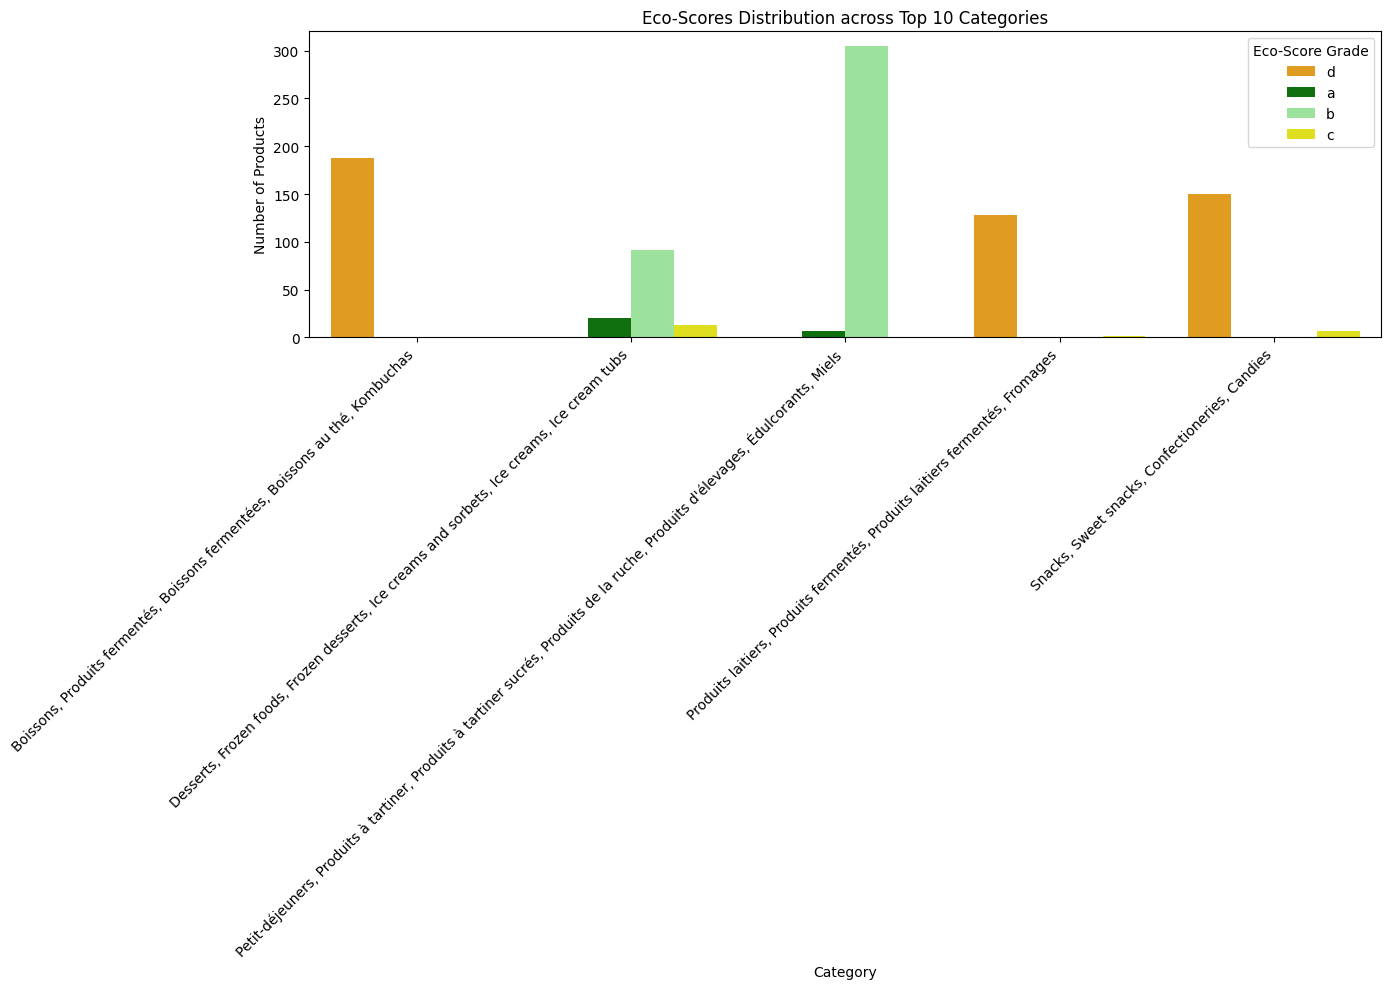

In [5]:


# Basic dataset statistics
def get_basic_stats():
    df = conn.execute("""
        SELECT COUNT(*) as total_products,
               COUNT(CASE WHEN ecoscore_score IS NOT NULL THEN 1 END) as products_with_eco_score,
               COUNT(CASE WHEN ecoscore_score IS NULL THEN 1 END) as products_without_eco_score,
               ROUND(COUNT(CASE WHEN ecoscore_score IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 2) as eco_score_percentage
        FROM products
    """).fetchdf()
    return df

# Distribution of eco-scores
def plot_eco_score_distribution():
    df = conn.execute("""
        SELECT ecoscore_score
        FROM products 
        WHERE ecoscore_score IS NOT NULL
    """).fetchdf()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='ecoscore_score', bins=30, kde=True)
    plt.title('Distribution of Eco-Scores')
    plt.xlabel('Eco-Score')
    plt.ylabel('Number of Products')
    plt.show()

# Distribution of eco-score grades
def plot_eco_score_grades():
    df = conn.execute("""
        SELECT ecoscore_grade,
               COUNT(*) as count
        FROM products
        WHERE ecoscore_grade IN ('a', 'b', 'c', 'd', 'e')
        GROUP BY ecoscore_grade
        ORDER BY ecoscore_grade
    """).fetchdf()
    
    plt.figure(figsize=(12, 8))
    colors = dict(zip(df['ecoscore_grade'], ['green', 'lightgreen', 'yellow', 'orange', 'red']))
    ax = sns.barplot(x='ecoscore_grade', y='count', data=df, palette=colors)
    plt.title('Distribution of Eco-Score Grades')
    plt.xlabel('Eco-Score Grade')
    plt.ylabel('Number of Products')
    
    # Add value labels on top of each bar
    for i, v in enumerate(df['count']):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    plt.show()

# Eco-score distribution across top categories
def plot_category_eco_scores():
    df = conn.execute("""
        SELECT 
            categories,
            ecoscore_grade,
            COUNT(*) as count
        FROM products
        WHERE ecoscore_grade IN ('a', 'b', 'c', 'd', 'e')
          AND categories IS NOT NULL
        GROUP BY categories, ecoscore_grade
        HAVING categories IN (
            SELECT categories
            FROM products
            GROUP BY categories
            ORDER BY COUNT(*) DESC
            LIMIT 10
        )
        ORDER BY categories, ecoscore_grade
    """).fetchdf()
    
    plt.figure(figsize=(14, 10))
    eco_score_colors = {'a': 'green', 'b': 'lightgreen', 'c': 'yellow', 'd': 'orange', 'e': 'red'}
    ax = sns.barplot(x='categories', y='count', hue='ecoscore_grade', data=df, palette=eco_score_colors)
    plt.title('Eco-Scores Distribution across Top 10 Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Products')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Eco-Score Grade')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Get and print basic statistics
    stats = get_basic_stats()
    print("Dataset Statistics:")
    print(stats)
    print("\n---\n")
    
    # Generate all plots
    plot_eco_score_distribution()
    plot_eco_score_grades()
    plot_category_eco_scores()
    
    # Close the database connection
    conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Descriptive Statistics for Numerical Columns:
        additives_n      complete  completeness     created_t  ecoscore_score  \
count  16156.000000  94802.000000  94802.000000  9.480200e+04    11707.000000   
mean       2.173372      0.001772      0.369969  1.639890e+09       49.877424   
std        2.707937      0.042059      0.170563  5.143923e+07       23.487195   
min        0.000000      0.000000      0.000000  1.328973e+09      -30.000000   
25%        0.000000      0.000000      0.275000  1.610924e+09       34.000000   
50%        1.000000      0.000000      0.300000  1.644697e+09       51.000000   
75%        3.000000      0.000000      0.375000  1.668921e+09       71.000000   
max       24.000000      1.000000      1.100000  1.737535e+09      116.000000   

       ingredients_from_palm_oil_n  ingredients_n  \
count                 13849.000000   16156.000000   
mean                      0.036176      17.434947   
std                       0.187891      16.516881   
min        

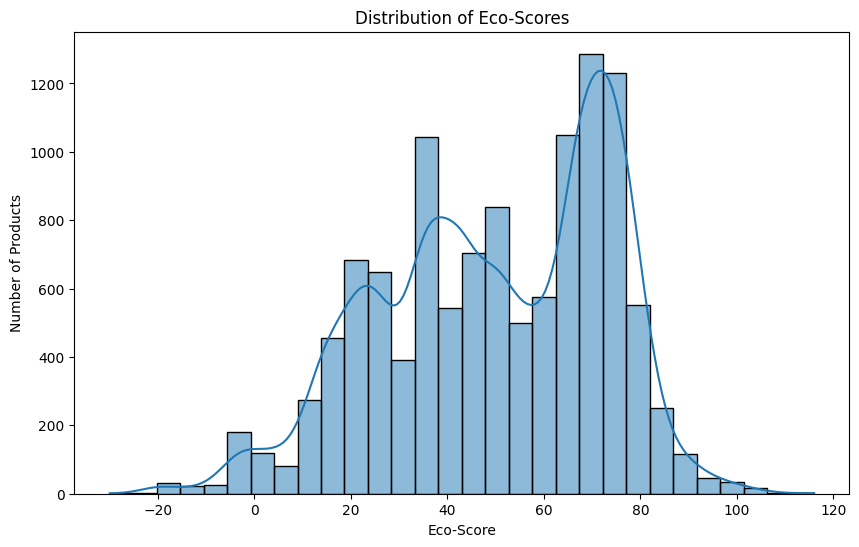

/var/folders/xz/c7tdt1ss5279tpg4_9p8r71h0000gn/T/ipykernel_46436/4000208919.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ecoscore_grade', y='count', data=df, palette=colors)


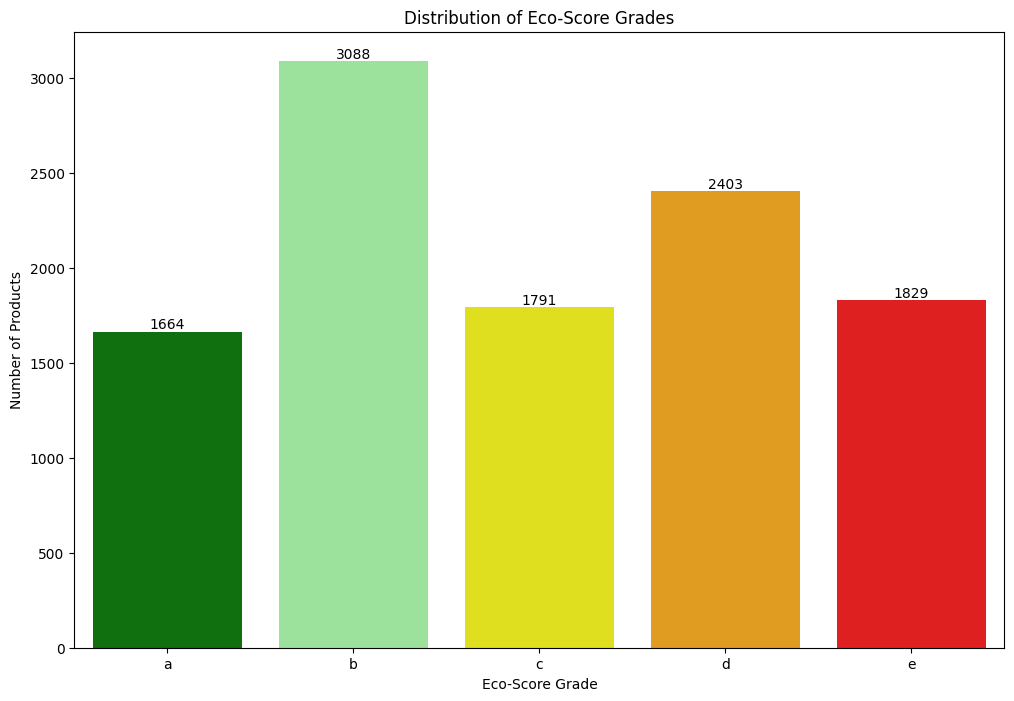

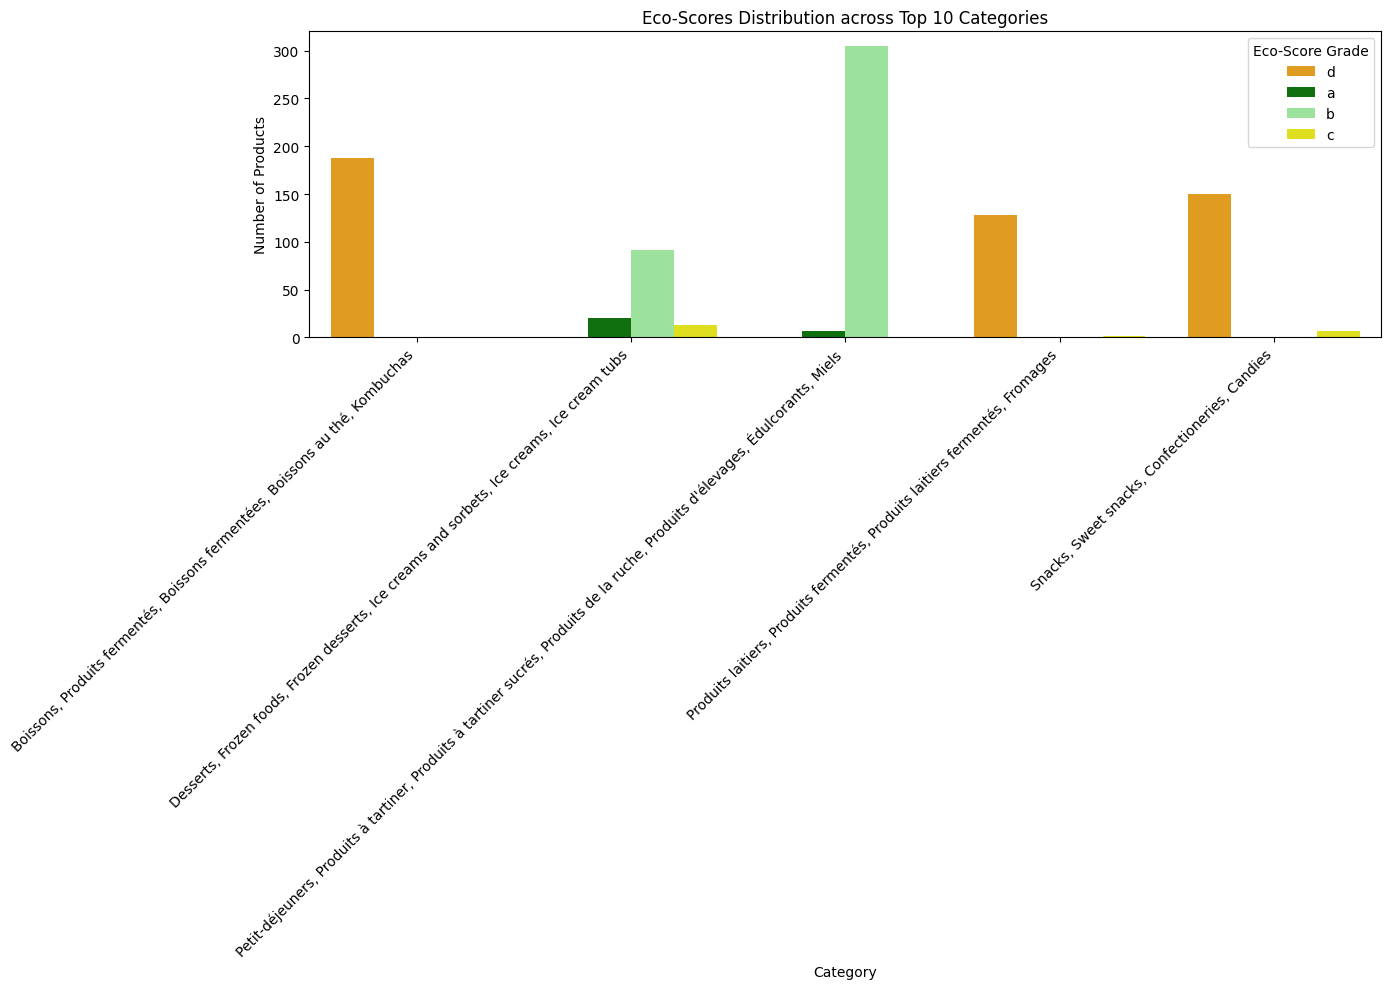


Packaging Information Coverage:
Products with packaging data: 8910 (9.40%)
Products without packaging data: 2 (0.00%)


In [7]:


def get_descriptive_stats():
    # Convert DuckDB table to pandas DataFrame for easier analysis
    df = conn.execute("SELECT * FROM products").fetchdf()
    
    # Basic statistics for numerical columns
    print("\nDescriptive Statistics for Numerical Columns:")
    print(df.describe())
    
    # Missing values analysis
    missing_percentage = df.isnull().mean() * 100
    missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
    
    print("\nColumns with highest percentages of missing values:")
    print(missing_percentage_sorted)
    
    return df

def analyze_eco_scores():
    # Count products with and without eco-scores
    eco_stats = conn.execute("""
        SELECT 
            COUNT(*) as total_products,
            COUNT(CASE WHEN ecoscore_score IS NOT NULL THEN 1 END) as products_with_eco_score,
            COUNT(CASE WHEN ecoscore_score IS NULL THEN 1 END) as products_without_eco_score
        FROM products
    """).fetchdf()
    
    print("\nEco-Score Coverage:")
    print(f"Total products: {eco_stats['total_products'][0]}")
    print(f"Products with eco-score: {eco_stats['products_with_eco_score'][0]}")
    print(f"Products without eco-score: {eco_stats['products_without_eco_score'][0]}")
    
    # Distribution of eco-scores
    plot_eco_score_distribution()
    plot_eco_score_grades()
    plot_category_eco_scores()

def plot_eco_score_distribution():
    df = conn.execute("""
        SELECT ecoscore_score
        FROM products 
        WHERE ecoscore_score IS NOT NULL
    """).fetchdf()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='ecoscore_score', bins=30, kde=True)
    plt.title('Distribution of Eco-Scores')
    plt.xlabel('Eco-Score')
    plt.ylabel('Number of Products')
    plt.show()

def plot_eco_score_grades():
    df = conn.execute("""
        SELECT ecoscore_grade,
               COUNT(*) as count
        FROM products
        WHERE ecoscore_grade IN ('a', 'b', 'c', 'd', 'e')
        GROUP BY ecoscore_grade
        ORDER BY ecoscore_grade
    """).fetchdf()
    
    plt.figure(figsize=(12, 8))
    colors = dict(zip(df['ecoscore_grade'], ['green', 'lightgreen', 'yellow', 'orange', 'red']))
    ax = sns.barplot(x='ecoscore_grade', y='count', data=df, palette=colors)
    plt.title('Distribution of Eco-Score Grades')
    plt.xlabel('Eco-Score Grade')
    plt.ylabel('Number of Products')
    
    # Add value labels
    for i, v in enumerate(df['count']):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    plt.show()

def plot_category_eco_scores():
    df = conn.execute("""
        SELECT 
            categories,
            ecoscore_grade,
            COUNT(*) as count
        FROM products
        WHERE ecoscore_grade IN ('a', 'b', 'c', 'd', 'e')
          AND categories IS NOT NULL
        GROUP BY categories, ecoscore_grade
        HAVING categories IN (
            SELECT categories
            FROM products
            GROUP BY categories
            ORDER BY COUNT(*) DESC
            LIMIT 10
        )
        ORDER BY categories, ecoscore_grade
    """).fetchdf()
    
    plt.figure(figsize=(14, 10))
    eco_score_colors = {'a': 'green', 'b': 'lightgreen', 'c': 'yellow', 'd': 'orange', 'e': 'red'}
    ax = sns.barplot(x='categories', y='count', hue='ecoscore_grade', data=df, palette=eco_score_colors)
    plt.title('Eco-Scores Distribution across Top 10 Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Products')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Eco-Score Grade')
    plt.tight_layout()
    plt.show()

def analyze_packaging():
    packaging_stats = conn.execute("""
        SELECT 
            COUNT(*) as total,
            COUNT(CASE WHEN packaging != 'unknown' THEN 1 END) as with_packaging,
            COUNT(CASE WHEN packaging = 'unknown' THEN 1 END) as without_packaging
        FROM products
    """).fetchdf()
    
    print("\nPackaging Information Coverage:")
    total = packaging_stats['total'][0]
    with_pkg = packaging_stats['with_packaging'][0]
    without_pkg = packaging_stats['without_packaging'][0]
    
    print(f"Products with packaging data: {with_pkg} ({(with_pkg/total)*100:.2f}%)")
    print(f"Products without packaging data: {without_pkg} ({(without_pkg/total)*100:.2f}%)")

if __name__ == "__main__":
    # Get general descriptive statistics
    df = get_descriptive_stats()
    
    # Analyze eco-scores
    analyze_eco_scores()
    
    # Analyze packaging information
    analyze_packaging()
    
    # Close the database connection
    conn.close()

In [ ]:
# Calculer le pourcentage de valeurs NaN et vides
missing = pd.DataFrame()
missing['null'] = df.isna().sum()
missing['empty'] = (df == '').sum()
missing['total_missing'] = missing['null'] + missing['empty']
missing['percent'] = (missing['total_missing'] / len(df)) * 100

# Trier par pourcentage décroissant
missing_sorted = missing.sort_values('percent', ascending=False)

print("\nColonnes avec le plus de valeurs manquantes:")
print(missing_sorted['percent'].round(2))

In [5]:
import pandas as pd

# https://world.openfoodfacts.org/data
# ?raw=true

CSV_PATH = "/Users/alain/Downloads/en.openfoodfacts.org.products.csv"
df = pd.read_csv(
    CSV_PATH,
     delimiter='\t',
     encoding='utf-8',nrows=10)
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1736276870,2025-01-07T19:07:50Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1732913331,2024-11-29T20:48:51Z,insectproductadd,1736256588,2025-01-07T13:29:48Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1737247862,2025-01-19T00:51:02Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1736961486,2025-01-15T17:18:06Z,smoothie-app,1737499513,2025-01-21T22:45:13Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1736849003,2025-01-14T10:03:23Z,prepperapp,1737510147,2025-01-22T01:42:27Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(10, 206)

In [7]:
df.describe()

,code,created_t,last_modified_t,last_updated_t,abbreviated_product_name,generic_name,packaging_text,cities,allergens_en,traces,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,35.700000,1.638010e+09,1.736210e+09,1.737252e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,45.033444,6.781168e+07,1.717713e+06,5.319061e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.560176e+09,1.732913e+09,1.736257e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.250000,1.580692e+09,1.736783e+09,1.737307e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.500000,1.620042e+09,1.736824e+09,1.737492e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,60.750000,1.706019e+09,1.736955e+09,1.737509e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,114.000000,1.732038e+09,1.737739e+09,1.737739e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 206 entries, code to acidity_100g
dtypes: float64(139), int64(5), object(62)
memory usage: 16.2+ KB


In [9]:
for i, col in enumerate(df.columns):
    print(f"{i}. {col}")

0. code
1. url
2. creator
3. created_t
4. created_datetime
5. last_modified_t
6. last_modified_datetime
7. last_modified_by
8. last_updated_t
9. last_updated_datetime
10. product_name
11. abbreviated_product_name
12. generic_name
13. quantity
14. packaging
15. packaging_tags
16. packaging_en
17. packaging_text
18. brands
19. brands_tags
20. categories
21. categories_tags
22. categories_en
23. origins
24. origins_tags
25. origins_en
26. manufacturing_places
27. manufacturing_places_tags
28. labels
29. labels_tags
30. labels_en
31. emb_codes
32. emb_codes_tags
33. first_packaging_code_geo
34. cities
35. cities_tags
36. purchase_places
37. stores
38. countries
39. countries_tags
40. countries_en
41. ingredients_text
42. ingredients_tags
43. ingredients_analysis_tags
44. allergens
45. allergens_en
46. traces
47. traces_tags
48. traces_en
49. serving_size
50. serving_quantity
51. no_nutrition_data
52. additives_n
53. additives
54. additives_tags
55. additives_en
56. nutriscore_score
57. nut

In [11]:
df[['image_url']].head()

,image_url
0,https://images.openfoodfacts.org/images/produc...
1,https://images.openfoodfacts.org/images/produc...
2,https://images.openfoodfacts.org/images/produc...
3,https://images.openfoodfacts.org/images/produc...
4,https://images.openfoodfacts.org/images/produc...


In [12]:
df['image_url'].iloc[0]

'https://images.openfoodfacts.org/images/products/000/000/000/0054/front_en.6.400.jpg'